<h1> Training <code>`color_saturation`</code> </h1>

**Labels:**
* color_saturation_desaturated
* color_saturation_neutral
* color_saturation_pastel
* color_saturation_saturated

We only want to do transfer learning i.e. create a new head and train that alone, because we need the body to remain the same across different categories aka. MobileNetV2 pretrained on ImageNet

In [ ]:
# Dynamically load package
%load_ext autoreload
%autoreload 2

# Display multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from fastai.vision import *
from fastai.callbacks import *
from ranger import Ranger

from CinemaNet.convert import *
from CinemaNet.blend import *
from CinemaNet.wandb import *
from CinemaNet.custom_head import *
from CinemaNet.train_utils import to_film_ar # other utils will be redefined for clarity

import wandb

In [ ]:
model_name = 'cat_color-saturation_MNetV2-150x266_tfr-lrn'

In [ ]:
wandb.init(name    = f"{re.sub('cat_[a-z].*_', '', model_name)}",
           project = 'color_saturation',
           entity  = 'synopsis',
           reinit  = True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/synopsis/color_saturation/runs/vq35euh5

In [ ]:
%env WANDB_NOTEBOOK_NAME='cat_color-saturation.ipynb'

env: WANDB_NOTEBOOK_NAME='cat_color-saturation.ipynb'


## Creating Train + Val Datasets

In [ ]:
path = '/home/rahul/datasets/Synopsis_Model_All_Concepts/color_saturation/'

### Viewing the frequency distribution of the labels in a random 20% split

In [ ]:
# presort + seed = full reproducibility on _any_ machine
img_list = ImageList.from_folder(path, presort=True)
data_split = img_list.split_by_rand_pct(0.2, seed=1234)

In [ ]:
len(data_split.train.items)

1709

In [ ]:
regex = {
    'color_saturation_desaturated' : '\/color_saturation_desaturated/',
    'color_saturation_neutral': '\/color_saturation_neutral/',
    'color_saturation_pastel': '\/color_saturation_pastel/',
    'color_saturation_saturated' : '\/color_saturation_saturated/',
}

In [ ]:
# train_split

fnames_all   = list(data_split.train.items)
count        = {}
train_fnames = {}
samples_per_label = 2000


for key in regex:
    i=0
    train_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            train_fnames[key].append(f)
            if i >= samples_per_label: break; 
pd.DataFrame([count]).T

0
color_saturation_desaturated  763
color_saturation_neutral      399
color_saturation_pastel       196
color_saturation_saturated    351

In [ ]:
# val_split

fnames_all   = list(data_split.valid.items)
count        = {}
train_fnames = {}
samples_per_label = 100

for key in regex:
    i=0
    train_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            train_fnames[key].append(f)
            if i >= samples_per_label: break; 
pd.DataFrame([count]).T

0
color_saturation_desaturated  100
color_saturation_neutral       85
color_saturation_pastel        50
color_saturation_saturated     89

### Create With Specific # of Samples per Label

Rounding off the # of validation samples for easier metrics interpretation

In [ ]:
n_desaturated = 200
n_neutral     = 100
n_pastel      = 50
n_saturated   = 100


In [ ]:
regex

{'color_saturation_desaturated': '\\/color_saturation_desaturated/',
 'color_saturation_neutral': '\\/color_saturation_neutral/',
 'color_saturation_pastel': '\\/color_saturation_pastel/',
 'color_saturation_saturated': '\\/color_saturation_saturated/'}

In [ ]:
# val_split

img_list = ImageList.from_folder(path, presort=True)
np.random.seed(1234)
np.random.shuffle(img_list.items)
fnames_all   = list(img_list.items)
count        = {}
valid_fnames = {}
samples_per_label = 100

for key in regex:
    i=0
    valid_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            valid_fnames[key].append(f)
            # refactor -- can't put it into a function
            if key == 'color_saturation_desaturated':
                if i >= n_desaturated: break;
            if key == 'color_saturation_neutral':     
                if i >= n_neutral: break;
            if key == 'color_saturation_pastel': 
                if i >= n_pastel: break;
            if key == 'color_saturation_saturated':
                if i >= n_saturated: break;
                    
count

{'color_saturation_desaturated': 200,
 'color_saturation_neutral': 100,
 'color_saturation_pastel': 50,
 'color_saturation_saturated': 100}

In [ ]:
# sanity check
len(valid_fnames['color_saturation_desaturated'])
len(valid_fnames['color_saturation_neutral'])
len(valid_fnames['color_saturation_pastel'])
len(valid_fnames['color_saturation_saturated'])

200

100

50

100

In [ ]:
fnames_valid = sum(valid_fnames.values(),[])
fnames_train = list(set(fnames_all) - set(fnames_valid))

In [ ]:
len(fnames_train)

1686

In [ ]:
lls = LabelLists(path,
                 train=ImageList(fnames_train),
                 valid=ImageList(fnames_valid))
lls

LabelLists;

Train: ImageList (1686 items)
Image (3, 500, 750),Image (3, 432, 640),Image (3, 571, 428),Image (3, 456, 1200),Image (3, 480, 950)
Path: .;

Valid: ImageList (450 items)
Image (3, 400, 600),Image (3, 683, 1023),Image (3, 750, 750),Image (3, 403, 604),Image (3, 651, 980)
Path: .;

Test: None

In [ ]:
#img_size   = to_film_ar(150)
img_size   = (224,224)
batch_size = 64

In [ ]:
tfms = get_transforms()
tfms = tfms[0], []      # remove cropping tfm from validation-transforms

In [ ]:
data = (lls
        .label_from_folder()
        .transform(tfms=get_transforms(),
                   size=img_size,
                   resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (1686 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
color_saturation_saturated,color_saturation_desaturated,color_saturation_desaturated,color_saturation_desaturated,color_saturation_pastel
Path: .;

Valid: LabelList (450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
color_saturation_desaturated,color_saturation_desaturated,color_saturation_desaturated,color_saturation_desaturated,color_saturation_desaturated
Path: .;

Test: None

In [ ]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes
vc

color_saturation_desaturated    766
color_saturation_neutral        384
color_saturation_pastel         196
color_saturation_saturated      340
dtype: int64

In [ ]:
vc = pd.value_counts(data.valid_ds.y.items, sort=False)
vc.index = data.classes
vc

color_saturation_desaturated    200
color_saturation_neutral        100
color_saturation_pastel          50
color_saturation_saturated      100
dtype: int64

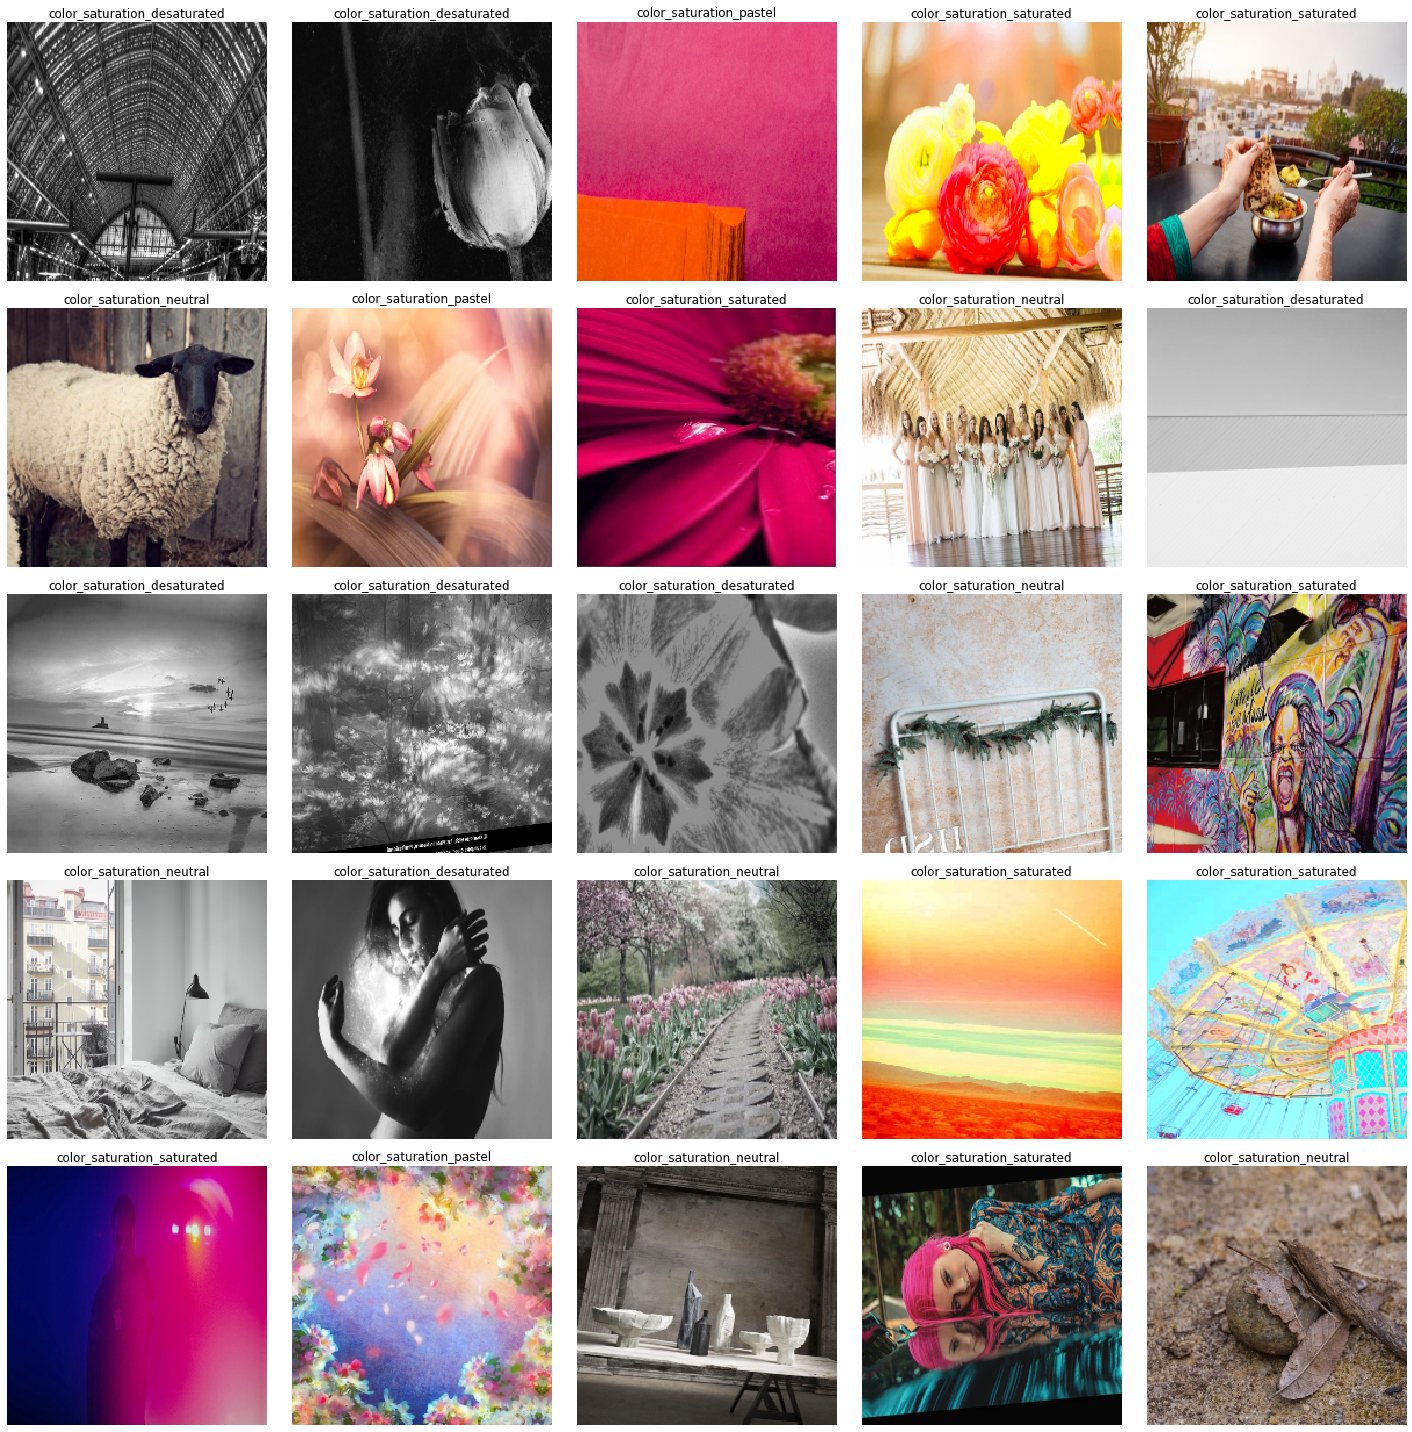

In [ ]:
data.show_batch()

## Model Setup

### Architecture, Loss Function, Optimiser

In [ ]:
arch = models.mobilenet_v2
loss_func = LabelSmoothingCrossEntropy()
opt_func  = Ranger

In [ ]:
model_name = f'{model_name}'
model_name

'cat_color-saturation_MNetV2-150x266_tfr-lrn'

In [ ]:
metrics = [accuracy, FBeta(), Precision(), Recall()]

def get_callbacks(learner, mod_name, monitor='accuracy'):
    return [
        SaveModelCallback(learner, name=mod_name, monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images',
                          log='all', predictions=100)
    ]

### Data Augmentations

`CutMix` is generally known to give better performance than `MixUp` (tentative), but this can be contextual.

Intuitively, `CutMix` is a good choice here, since you don't need to see the entire image to classify it. In the case of `shot_framing`, `MixUp` would be a better choice

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


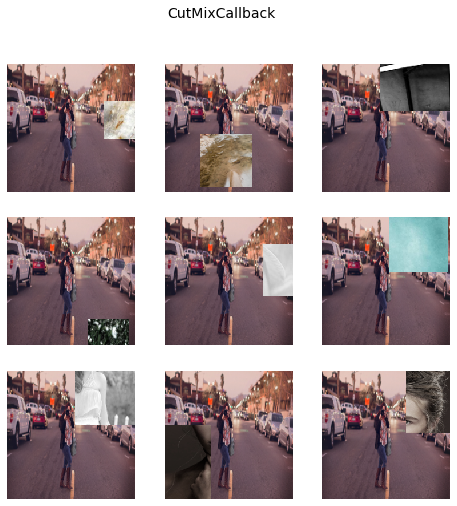

In [ ]:
_ = Learner(data,arch()).cutmix().show_tfms()

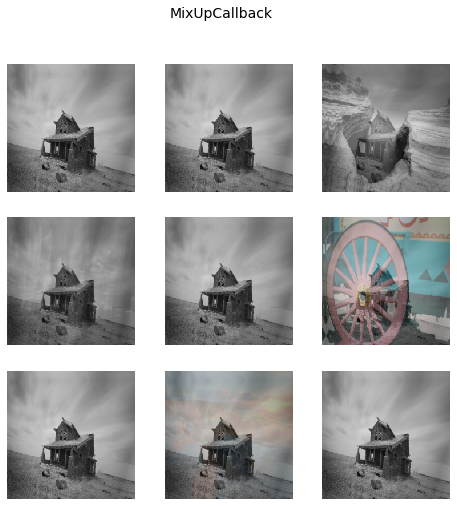

In [ ]:
_ = Learner(data,arch()).mixup().show_tfms()

### Model

In [ ]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics, opt_func=opt_func, 
                    loss_func=loss_func, callback_fns=callbacks)
learn = learn.cutmix()

## Training

### Flat cosine annealing w/ Ranger (Lookahead + RAdam) Optimiser

In [ ]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics, opt_func=opt_func, 
                    loss_func=loss_func)
learn = learn.cutmix()

In [ ]:
learn.save(model_name) # avoid potential `SaveModelCallback` bugs

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 5.25E-02


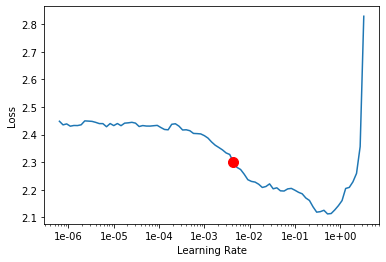

In [ ]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [ ]:
model_name

'cat_color-saturation_MNetV2-150x266_tfr-lrn'

In [ ]:
model_name = f'{model_name}-opt_ranger-cosine_anneal'
callbacks = get_callbacks(learn, model_name)

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.7822222113609314.
Better model found at epoch 0 with accuracy value: 0.7822222113609314.
Better model found at epoch 1 with accuracy value: 0.851111114025116.
Better model found at epoch 1 with accuracy value: 0.851111114025116.
Better model found at epoch 3 with accuracy value: 0.8577777743339539.
Better model found at epoch 3 with accuracy value: 0.8577777743339539.
Better model found at epoch 5 with accuracy value: 0.8777777552604675.
Better model found at epoch 5 with accuracy value: 0.8777777552604675.
Better model found at epoch 7 with accuracy value: 0.8999999761581421.
Better model found at epoch 7 with accuracy value: 0.8999999761581421.
Better model found at epoch 9 with accuracy value: 0.9044444561004639.
Better model found at epoch 9 with accuracy value: 0.9044444561004639.
Better model found at epoch 11 with accuracy value: 0.9111111164093018.
Better model found at epoch 11 with accuracy value: 0.9111111164093018.
Better

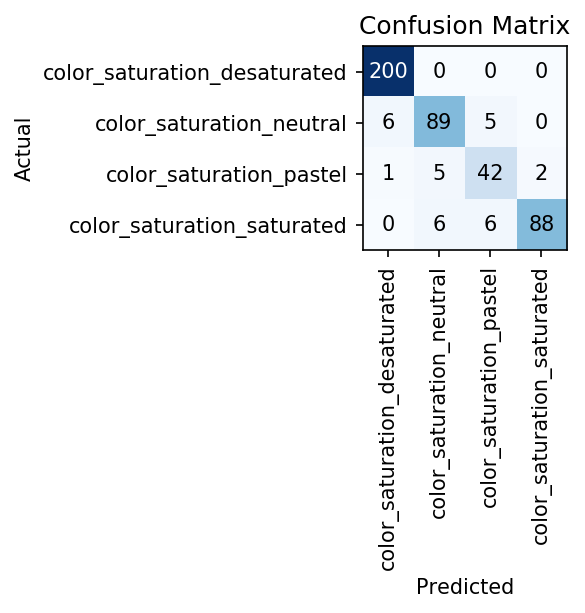

In [ ]:
# start_pct=0.3 --> start anneaing lr after 0.2*25 = 5 epochs
learn.fit_fc(25, 5e-3, wd=1e-2, callbacks=callbacks, start_pct=0.3)

## Interpretation

In [ ]:
interpret = learn.interpret()

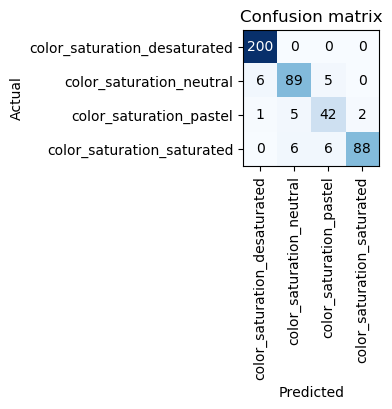

In [ ]:
interpret.plot_confusion_matrix(dpi=100)

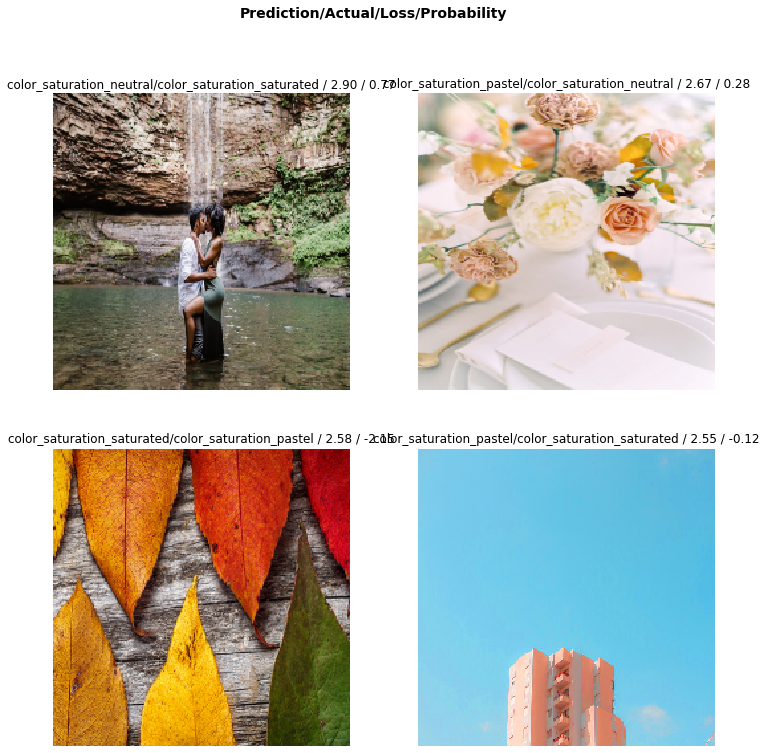

In [ ]:
interpret.plot_top_losses(4)

In [ ]:
interpret.most_confused()

[('color_saturation_neutral', 'color_saturation_desaturated', 6),
 ('color_saturation_saturated', 'color_saturation_neutral', 6),
 ('color_saturation_saturated', 'color_saturation_pastel', 6),
 ('color_saturation_neutral', 'color_saturation_pastel', 5),
 ('color_saturation_pastel', 'color_saturation_neutral', 5),
 ('color_saturation_pastel', 'color_saturation_saturated', 2),
 ('color_saturation_pastel', 'color_saturation_desaturated', 1)]

It's clear that the labels that need more labelling are  `color_saturation_saturated` and `color_saturation_pastel`

## Rename Files & Save to Weights & Biases

In [ ]:
model_name

'cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal'

In [ ]:
learn.load(model_name); # this is just a sanity check, out callbacks would have loaded the best model anyways

set state called


In [ ]:
f'{model_name}-FULL'
f'{model_name}-HEAD'

'cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-FULL'

'cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-HEAD'

In [ ]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2560, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
torch_to_coreml(learn.model, data.c, model_fname=f'{model_name}-FULL')

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Converting Node Type Add
26/162: Converting Node Type Conv


In [ ]:
!ls -l ../exported-models/{model_name}*

-rw-rw-r-- 1 rahul rahul 14342744 Feb  8 19:22 ../exported-models/cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-FULL.mlmodel
-rw-rw-r-- 1 rahul rahul 14353213 Feb  8 19:22 ../exported-models/cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-FULL.onnx


In [ ]:
wandb.save(f'../exported-models/{model_name}*')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200208_131136-vq35euh5/cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-FULL.onnx',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200208_131136-vq35euh5/cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-FULL.mlmodel']

In [ ]:
!ls {learn.path}/{model_name}*csv

/home/rahul/datasets/Synopsis_Model_All_Concepts/color_saturation/cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-history.csv


In [ ]:
wandb.save(f'{learn.path}/{model_name}*csv')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200208_131136-vq35euh5/cat_color-saturation_MNetV2-150x266_tfr-lrn-opt_ranger-cosine_anneal-history.csv']